In [1]:
%load_ext autoreload
%load_ext memory_profiler 
%load_ext dotenv
%autoreload 2
%dotenv

In [2]:
from lightning import Trainer
from torchvision.transforms import v2 as T # type: ignore
from geovision.logging import get_logger
from geovision.config.basemodels import ExperimentConfig # noqa
from geovision.data.module import ImageDatasetDataModule
from geovision.io.local import get_ckpt_path, get_experiments_dir
from geovision.training.module import ClassificationModule
from geovision.training.loggers import (
    get_csv_logger, 
    get_wandb_logger,
    get_ckpt_logger,
    get_lr_logger,
    get_classification_logger
)

In [3]:
from torch import float32
from geovision.data.imagenette import Imagenette

logger = get_logger("experiment_logger")
transforms: dict[str, T.Transform | None] = {
    "image_transform": T.Compose([
        T.ToImage(), 
        T.Resize((224, 224), antialias=True), 
        T.ToDtype(float32, scale = True),
        T.Normalize(Imagenette.means, Imagenette.std_devs),
    ]),
    "target_transform": None,
    "common_transform": None
    # "common_transform": T.RandomChoice([
        # T.RandomHorizontalFlip(0.5),
        # T.RandomVerticalFlip(0.5),
        # T.RandomInvert(0.5),
        # T.RandomAutocontrast(0.5)
    # ]),
}
config = ExperimentConfig.from_yaml("config.yaml", transforms)
experiments_dir = get_experiments_dir(config)
datamodule = ImageDatasetDataModule(config)

loggers: list = list()
loggers.append(csv_logger := get_csv_logger(config))
#loggers.append(wandb_logger := get_wandb_logger(config))

callbacks: list = list()
callbacks.append(ckpt_logger := get_ckpt_logger(config))
#callbacks.append(metrics_logger := get_classification_logger(config))
#callbacks.append(lr_logger := get_lr_logger(config))
#callbacks.append(LearningRateFinder(num_training_steps=147, early_stop_threshold=None))

In [9]:
trainer = Trainer(
    max_epochs = 6,
    check_val_every_n_epoch = 1,
    num_sanity_val_steps = 0,
    log_every_n_steps = 1,

    logger = loggers,
    callbacks = callbacks,
    enable_checkpointing = True,
    enable_model_summary = False
)

litmodule = ClassificationModule(ExperimentConfig.from_yaml("config.yaml", transforms))
trainer.fit(
    model = litmodule,
    datamodule = datamodule,
    ckpt_path = get_ckpt_path(config)
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


"found ckpts: ['epoch=0_step=147.ckpt', '*epoch=1_step=294.ckpt']"

/home/sambhav/miniconda3/envs/dev/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/sambhav/experiments/imagenette_classification/testing_plotting/ckpts exists and is not empty.
Restoring states from the checkpoint path at /home/sambhav/experiments/imagenette_classification/testing_plotting/ckpts/epoch=1_step=294.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restored all states from the checkpoint at /home/sambhav/experiments/imagenette_classification/testing_plotting/ckpts/epoch=1_step=294.ckpt


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=6` reached.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)

df = pd.read_csv(experiments_dir / "metrics.csv")
df["epoch"] = df["epoch"].ffill()
#df = df[["epoch", "step", "train/loss_epoch"]]
df

,epoch,step,train/f1_epoch,train/loss_epoch,train/loss_step,val/f1_epoch,val/f1_step,val/loss_epoch,val/loss_step
0,0.0,0,NaN,NaN,2.409277,NaN,NaN,NaN,NaN
1,0.0,1,NaN,NaN,2.554533,NaN,NaN,NaN,NaN
2,0.0,2,NaN,NaN,2.455010,NaN,NaN,NaN,NaN
3,0.0,3,NaN,NaN,2.520337,NaN,NaN,NaN,NaN
4,0.0,4,NaN,NaN,2.621674,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1017,5.0,82,NaN,NaN,NaN,NaN,0.859375,NaN,0.449243
1018,5.0,83,NaN,NaN,NaN,NaN,0.890625,NaN,0.443564
1019,5.0,84,NaN,NaN,NaN,NaN,0.898305,NaN,0.380588
1020,5.0,881,NaN,NaN,NaN,0.918596,NaN,0.360602,NaN


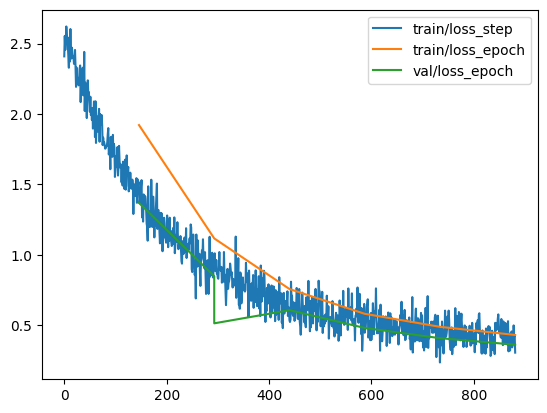

In [11]:
tlsdf = df[["step", "train/loss_step"]].dropna(axis=0).reset_index(drop=True)
xts, yts = tlsdf["step"], tlsdf["train/loss_step"]
plt.plot(xts, yts, label = "train/loss_step")

tledf = df[["step", "train/loss_epoch"]].dropna(axis=0).reset_index(drop=True)
xte, yte = tledf["step"], tledf["train/loss_epoch"]
plt.plot(xte, yte, label = "train/loss_epoch")

vledf = df[["step", "val/loss_epoch"]].dropna(axis=0).reset_index(drop=True)
xve, yve = vledf["step"], vledf["val/loss_epoch"]
plt.plot(xve, yve, label = "val/loss_epoch")

#plt.ylim((0, 6))
plt.legend()

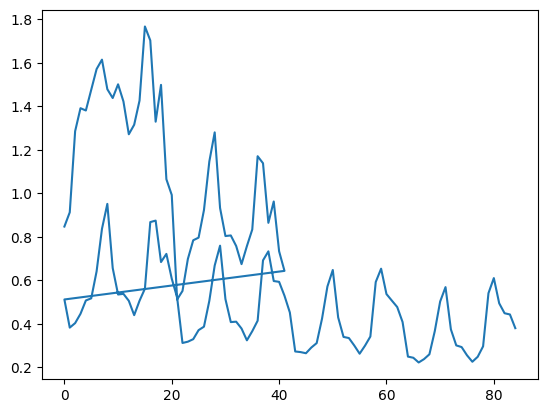

In [12]:
vlsdf = df[["epoch", "step", "val/loss_step"]].dropna(axis=0).reset_index(drop=True)
xvs, yvs = vlsdf["step"], vlsdf["val/loss_step"]
plt.plot(xvs, yvs, label = "val/loss_step")
# pd.set_option("display.max_rows", None)
# vlsdf

In [13]:
vmedf = df[["epoch", "step", f"val/{config.metric}_epoch"]].dropna(axis=0).reset_index(drop=True)
xve, yve = vmedf["step"], vmedf["epoch"]

tmedf = df[["epoch", "step", f"train/{config.metric}_epoch"]].dropna(axis=0).reset_index(drop=True)
xte, yte = tmedf["step"], tmedf["epoch"]

#plt.plot(xve, yve, label = "val/iou")
#plt.plot(xte, yte, label = "train/iou")
display(vmedf)
display(tmedf)

,epoch,step,val/f1_epoch
0,0.0,146,0.666169
1,1.0,293,0.848394
2,1.0,293,0.921875
3,2.0,440,0.884989
4,3.0,587,0.905153
5,4.0,734,0.914115
6,5.0,881,0.918596


,epoch,step,train/f1_epoch
0,0.0,146,0.352816
1,1.0,293,0.726962
2,2.0,440,0.819966
3,3.0,587,0.857082
4,4.0,734,0.870627
5,5.0,881,0.883532
